Train 4 different classifiers using sklearn library to predict "Activity" (biological response of the molecule) field from the "bioresponse.csv" dataset:
- small decision tree;
- deep decision tree;
- random forest on small trees;
- random forest on deep trees;
Refer to ‘Random_Forrest.ipynb’ and ‘Decision_Trees.ipynb’ notebooks for examples. Split the data to train and test as 75% / 25%.

2. Calculate the following metrics to check the quality of your models:
- precision;
- recall;
- accuracy;
- F1-score;
- log-loss;
3. Plot precision-recall and ROC curves for your models.
4. Train a classifier who avoids Type II (False Negative) errors and calculate metrics from p.2 for it. 
Recall for it should be larger than 0.95.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score,\
                            log_loss, roc_curve, roc_auc_score, precision_recall_curve, auc, classification_report
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from tqdm import tqdm

In [2]:
def get_metrics(model, X_test, y_test, info=False):
    y_predict = model.predict(X_test)

    metrics = {
        'accuracy': accuracy_score,
        'recall': recall_score,
        'precision': precision_score,
        'f1': f1_score,
        'log_loss': log_loss
    }

    results = {metric: round(metrics[metric](y_test, y_predict), 3) for metric in metrics}
    
    if info:
        for metric in metrics:
            print(f'{metric:10} = {results[metric]}')
    
    return results

In [3]:
df = pd.read_csv('bioresponse.csv')

In [4]:
X = df.iloc[:, 1:]
y = df.Activity

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [6]:
small_tree_model = DecisionTreeClassifier(max_depth=2, random_state=42)
deep_tree_model = DecisionTreeClassifier(max_depth=20, random_state=42)
small_forest_model = RandomForestClassifier(n_estimators=20, max_depth=2, random_state=42)
deep_forest_model = RandomForestClassifier(n_estimators=20, max_depth=20, random_state=42)

models = {
    'small_tree': small_tree_model,
    'deep_tree': deep_tree_model,
    'small_forest': small_forest_model,
    'deep_forest': deep_forest_model,
}

In [7]:
for model_key in tqdm(models):
    models[model_key].fit(X_train, y_train)

100%|██████████| 4/4 [00:01<00:00,  3.61it/s]


In [8]:
for model_key in tqdm(models):
    print(model_key)
    get_metrics(models[model_key], X_test, y_test, info=True)
    print('-------')

100%|██████████| 4/4 [00:00<00:00, 50.09it/s]

small_tree
accuracy   = 0.745
recall     = 0.854
precision  = 0.728
f1         = 0.786
log_loss   = 9.184
-------
deep_tree
accuracy   = 0.725
recall     = 0.755
precision  = 0.746
f1         = 0.75
log_loss   = 9.914
-------
small_forest
accuracy   = 0.661
recall     = 0.778
precision  = 0.662
f1         = 0.716
log_loss   = 12.219
-------
deep_forest
accuracy   = 0.783
recall     = 0.805
precision  = 0.799
f1         = 0.802
log_loss   = 7.839
-------


In [9]:
metrics_for_auc = {}
for model in tqdm(models):
    y_scores = models[model].predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    
    _auc = roc_auc_score(y_test, y_scores)
    metrics_for_auc[model] = fpr, tpr, _auc

100%|██████████| 4/4 [00:00<00:00, 58.63it/s]


In [10]:
metrics_for_roc = {}
for model in tqdm(models):
    y_scores = models[model].predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    auc_pr_score = auc(recall, precision)
    # auc = roc_auc_score(y_test, y_scores)
    metrics_for_roc[model] = precision, recall, auc_pr_score

100%|██████████| 4/4 [00:00<00:00, 63.48it/s]


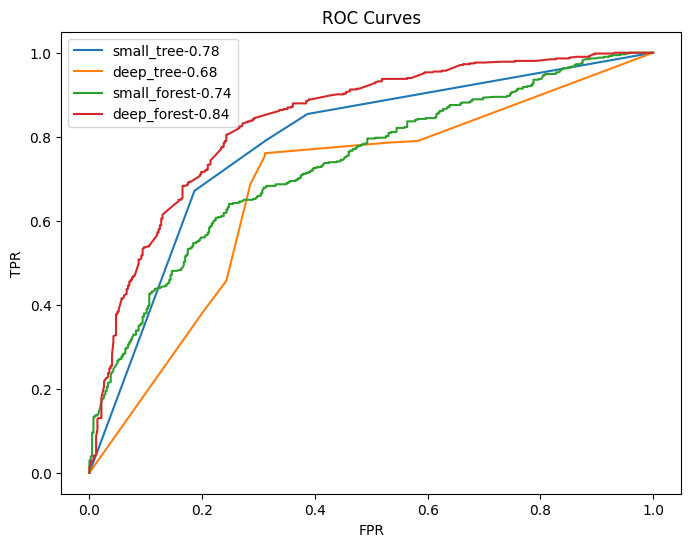

In [11]:
# for plot_data in metrics_for_plot:
# recall, precision = metrics_for_plot['deep_tree']
plt.figure(figsize=(8, 6))
for model in models:
    fpr, tpr, _auc = metrics_for_auc[model]
    plt.plot(fpr, tpr, label=f'{model}-{_auc:.2}')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curves')
plt.legend()
plt.show()

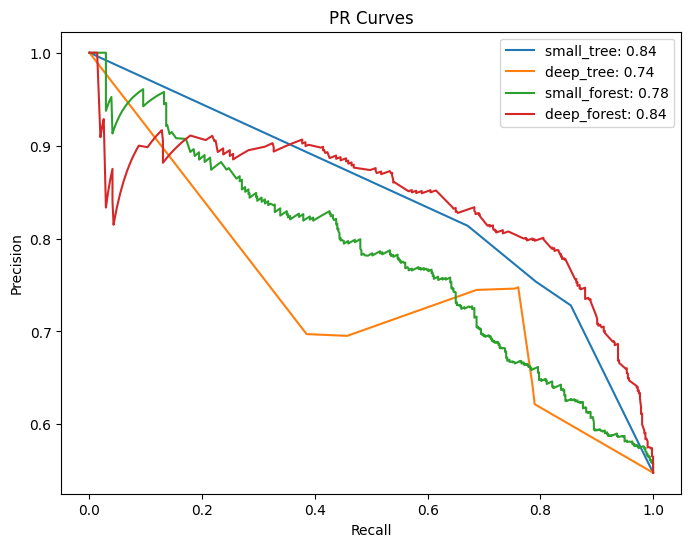

In [12]:
# for plot_data in metrics_for_plot:
# recall, precision = metrics_for_plot['deep_tree']
plt.figure(figsize=(8, 6))
for model in models:
    precision, recall, score = metrics_for_roc[model]
    plt.plot(recall, precision, label=f'{model}: {score:.2}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curves')
plt.legend()
plt.show()

Trying to reach RECALL = 0.95. For example, let's use RandomForest

In [13]:
model = RandomForestClassifier()

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
recall_score(y_test, y_pred)

np.float64(0.8261682242990654)

Basic resuls is 0.81. Let's making some changing

In [15]:
param_grid = {
    'max_depth': [1, 2, 5, 10, 20, 30],  
}

In [16]:
grid = GridSearchCV(model, param_grid, refit=True, verbose=3, n_jobs=-1)
grid.fit(X_train, y_train)
print(grid.best_params_)
y_pred = grid.predict(X_test)
recall_score(y_test, y_pred)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
{'max_depth': 30}


np.float64(0.8168224299065421)

Not much better. Let's use more parameters

In [17]:
param_grid = {
    'max_depth': [1, 2, 5, 10, 20, 30],
    'n_estimators': [1, 10, 20, 40, 100, 200],
}

In [18]:
grid = GridSearchCV(model, param_grid, refit=True, verbose=3, n_jobs=-1)
grid.fit(X_train, y_train)
print(grid.best_params_)
y_pred = grid.predict(X_test)
recall_score(y_test, y_pred)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


C:\Users\Ilia\ITMO_algorithms\machine_learning\.venv\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


{'max_depth': 20, 'n_estimators': 200}


np.float64(0.8205607476635514)

The same result

In [19]:
param_grid = {
    'max_depth': [1, 2, 5, 10, 20, 30],
    'n_estimators': [1, 10, 20, 40, 100, 200],
    'criterion': ['gini', 'entropy', 'log_loss'],
}

In [20]:
grid = GridSearchCV(model, param_grid, refit=True, verbose=3, n_jobs=-1)
grid.fit(X_train, y_train)
print(grid.best_params_)
y_pred = grid.predict(X_test)
recall_score(y_test, y_pred)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'criterion': 'gini', 'max_depth': 20, 'n_estimators': 200}


np.float64(0.8261682242990654)

In [21]:
thresholds = np.arange(0.1, 1, 0.1)

for threshold in thresholds:
    predicted_proba = grid.predict_proba(X_test)
    predicted = (predicted_proba [:, 1] >= threshold).astype('int')
    print(threshold)
    print(recall_score(y_test, predicted))
    print('------------')

0.1
0.9981308411214953
------------
0.2
0.983177570093458
------------
0.30000000000000004
0.9607476635514018
------------
0.4
0.897196261682243
------------
0.5
0.8261682242990654
------------
0.6
0.708411214953271
------------
0.7000000000000001
0.577570093457944
------------
0.8
0.38878504672897196
------------
0.9
0.18691588785046728
------------


In [22]:
# Let's create self owned RandomForestClassifier!!! Threshold should be less than 0.5. For example 0.25

In [23]:
class CustomRandomForestClassifier(RandomForestClassifier):
    def __init__(self, threshold, **kwargs):
        super().__init__(**kwargs)
        self.threshold = threshold

    def predict(self, X):
        y_pred_proba = super().predict_proba(X)
        y_pred = (y_pred_proba[:, 1] > self.threshold).astype(int)
        return y_pred

    def fit(self, X, y, sample_weight=None):
        super().fit(X, y, sample_weight)

In [24]:
model = CustomRandomForestClassifier(threshold=0.25)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
recall_score(y_test, y_pred)

np.float64(0.9757009345794393)

In [25]:
list_of_recall = []
for random_state in tqdm(range(100)):
    model = CustomRandomForestClassifier(threshold=0.25)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=random_state)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    list_of_recall.append(recall_score(y_test, y_pred))

100%|██████████| 100/100 [02:12<00:00,  1.33s/it]


In [26]:
np.quantile(list_of_recall, 0.025)

np.float64(0.9482473273026315)

In [27]:
np.quantile(list_of_recall, 0.975)

np.float64(0.9825963409158934)

0.95 in interval (0.949, 0.983), it almost like coinfedence interval. The task is done